$f(x,y) = - \left(\dfrac{3}{(x^2+ 8)} + \dfrac{5}{(y^2+ 8)}\right)$

Адаптивная оценка момента. Adam. Едленко 4к. 6г.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os.path
from google.colab import files

In [2]:
def my_func(x,y):
    return -((3 / (x*x + 8)) + (5 / (y*y + 8)))

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_diff(y):
    return y*(1 - y)

In [4]:
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [5]:
class NeuralNetwork:
    def __init__(self, x, y, batch_size):
        #Входные данные
        self.input      = np.array([x[0].ravel(), x[1].ravel()])
        self.y          = np.array(y).ravel()
        self.diam_s     = 4
        self.alpha      = 0.001

        self.weights1   = np.random.rand(self.diam_s, self.input.shape[0])
        self.weights2   = np.random.rand(1, self.diam_s)
        self.bias       = np.random.rand(self.diam_s, 1)
        self.b          = np.random.rand()

        #Создаем батч заданного размера
        self.output     = np.zeros(self.y.shape)
        self.batch      = batch_size
        self.shuff      = np.arange(self.input.shape[1])
        np.random.shuffle(self.shuff)

        #Данные для Adam

        self.count_iter = 0
        self.M_weights2 = np.zeros(self.weights2.shape)
        self.M_weights1 = np.zeros(self.weights1.shape)
        self.M_bias     = np.zeros(self.bias.shape)
        self.M_b        = 0
        self.V_weights2 = np.zeros(self.weights2.shape)
        self.V_weights1 = np.zeros(self.weights1.shape)
        self.V_bias     = np.zeros(self.bias.shape)
        self.V_b        = 0
        self.b1         = 0.9
        self.b2         = 0.99
        self.eps        = 0.000000001
        
    #Ф-ия прямого распространения
    def feedforward(self):
        for i in np.arange(self.input.shape[1] // self.batch + int(bool(self.input.shape[1] % self.batch))):
            batch_i = self.shuff[i*self.batch : (i+1)*self.batch]
            self.layer1 = sigmoid(np.dot(self.weights1, self.input[:,batch_i]) + self.bias) #kxm
            self.output = np.dot(self.weights2, self.layer1) + self.b # 1xm
            self.backprop(batch_i)

    #Ф-ия обратного распространения
    def backprop(self, batch):
        d_weights2 = 2*np.dot((self.y[batch] - self.output),self.layer1.T)
        d_weights1 = 2*self.weights2.T*np.dot((self.y[batch] - self.output)*sigmoid_diff(self.layer1),self.input.T[batch] )
        d_bias     = 2*self.weights2.T*np.dot(sigmoid_diff(self.layer1), (self.y[batch] - self.output).T)
        d_b        = 2*(self.y[batch] - self.output).sum()
        self.count_iter += 1

        self.M_weights2 = self.b1 * self.M_weights2 + (1 - self.b1) * d_weights2
        self.M_weights1 = self.b1 * self.M_weights1 + (1 - self.b1) * d_weights1
        self.M_bias     = self.b1 * self.M_bias + (1 - self.b1) * d_bias
        self.M_b        = self.b1 * self.M_b + (1 - self.b1) * d_b

        self.V_weights2 = self.b2 * self.V_weights2 + (1 - self.b2) * d_weights2**2
        self.V_weights1 = self.b2 * self.V_weights1 + (1 - self.b2) * d_weights1**2
        self.V_bias     = self.b2 * self.V_bias + (1 - self.b2) * d_bias**2
        self.V_b        = self.b2 * self.V_b + (1 - self.b2) * d_b**2

        self.weights2 += self.alpha * (self.M_weights2 / (1 - self.b1 ** self.count_iter)) / np.sqrt((self.V_weights2 / (1 - self.b2 ** self.count_iter)) + self.eps)
        self.weights1 += self.alpha * (self.M_weights1 / (1 - self.b1 ** self.count_iter)) / np.sqrt((self.V_weights1 / (1 - self.b2 ** self.count_iter)) + self.eps)
        self.bias     += self.alpha * (self.M_bias / (1 - self.b1 ** self.count_iter)) / np.sqrt((self.V_bias / (1 - self.b2 ** self.count_iter)) + self.eps)
        self.b        += self.alpha * (self.M_b / (1 - self.b1 ** self.count_iter)) / np.sqrt((self.V_b / (1 - self.b2 ** self.count_iter)) + self.eps)

    def result(self, t):
        return np.dot(self.weights2, sigmoid(np.dot(self.weights1, t) + self.bias)) + self.b

In [6]:
X = np.arange(-20, 20, 1)
Y = np.arange(-20, 20, 1)
X, Y = np.meshgrid(X, Y)
X1, Y1 = X.ravel(), Y.ravel()
Z1 = my_func(X1, Y1)
Xd = np.array([X1,Y1])
Xd.shape
Zd = np.array([list(Z1)])
Zd.shape
z = NeuralNetwork(Xd,Zd, 100)

In [10]:
i = 0
while(mse_loss(Zd, z.result(Xd)) > 0.001):
    z.feedforward()
    i+=1
    if(i % 1000 == 0):
      print(mse_loss(Zd, z.result(Xd)))
    if(i > 100000):
      break

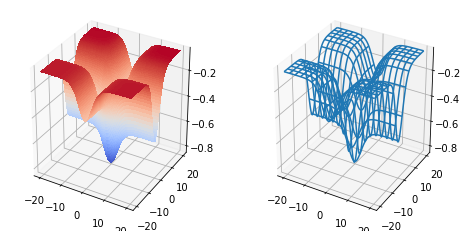

In [8]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20.25, 0.25)
Y = np.arange(-20, 20.25, 0.25)
X, Y = np.meshgrid(X, Y)

Z = z.result(np.array([X.ravel(),Y.ravel()])).reshape((161,161))

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

weights1 =  [[0.22159329 0.22046204]
 [0.35075768 0.22987254]
 [0.507249   0.85013574]
 [0.4482291  0.26280861]
 [0.05210029 0.89361754]] 
 weights2 =  [[0.72699017 0.11493938 0.5833895  0.72083276 0.364271  ]] 
 bias =  [[0.27112213]
 [0.50669698]
 [0.20077828]
 [0.13666401]
 [0.62507977]] 
 b =  0.8431832054956001